In [1]:
import dicom
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import scipy.misc
from skimage import io
import scipy.stats
import seaborn as sns
import skimage.color
from skimage.filters import threshold_otsu
import keras

from matplotlib import animation
from IPython.display import HTML
from PIL import Image
import pandas as pd
import nibabel as nib
from nibabel.testing import data_path

Using TensorFlow backend.


[[[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 ..., 
 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., 

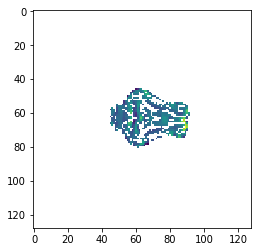

In [2]:
realigned_atlas = nib.load('../../Data/big_atlas/coregistered_pig_2_atlas.nii').get_data()
#original_atlas = nib.load('../../Data/big_atlas/atlas.nii').get_data()
anatomical = nib.load('../../Data/pig_2/coregistered_anatomy.nii').get_data()
mean_fmri = nib.load('../../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii').get_data()  

mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)
fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), mean_fmri) 
print(fmri_masked_roi)
plt.imshow(fmri_masked_roi[:,:,10])

In [4]:
# let's try loading the entire thing to ram
# the big tensor will have dimension [time, height, width, depth]

im = mean_fmri
all_data = np.zeros((300, im.shape[0], im.shape[1], im.shape[2]))
masked_data = np.ma.zeros((300, im.shape[0], im.shape[1], im.shape[2]))

dicom_files = [x for x in Path('../../Data/pig_2/rfmri files/').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)
time_index = 0
mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)

for f in tqdm_notebook(dicom_files):
    time_file = nib.load(str(f)).get_data()
    fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), time_file) 
    try:
        masked_data[time_index, ...] = fmri_masked_roi
        all_data[time_index, ...] = time_file
        time_index += 1
    except:
        print(f)

In [5]:
assert all_data.shape == (300, 128, 128, 20) #300 time samples, 128x128 image, over 20 slices in z-index
assert masked_data.shape == (300, 128, 128, 20) # basic sanity check

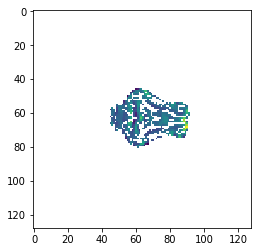

In [6]:
plt.imshow(masked_data[1,:,:,10]) # Mask is generated from an atlas, atlas disregards certain subcortical regions that are just "grey matter"

In [7]:
indices = masked_data[1,:,:,:].nonzero()
df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['row', 'col', 'depth'])
series_df = pd.Series(index=df_index, dtype=object)

for i, triple in tqdm_notebook(enumerate(zip(*indices)), total=len(indices[0])):
    x, y, z = triple
    trace = all_data[:, x, y, z]
    
    series_df.loc[triple] = trace

data_block = np.vstack(series_df.values)[..., np.newaxis]



In [8]:
def model():
    from keras.layers.convolutional import Conv1D, UpSampling1D
    from keras.layers.pooling import MaxPooling1D
    from keras.layers.core import Dense, Activation
    from keras.layers.normalization import BatchNormalization
    
    model = keras.models.Sequential()
      
    # encoder
    model.add(Conv1D(64, 20, padding='causal', input_shape=[300, 1])) #Dimensionality 300
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(32, 20, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Conv1D(16, 20, padding='causal')) # Activation map size [150 x 1]
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Conv1D(8, 20, padding='causal')) # Activation map size [75 x 1]
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3))
    
    # Activation map size [25 x 1] 
    # Encoding represenation size is [25 x 1 x N (8)] = 200
    # Dimensionality reduction of 300 -> 200
    
    # decoder
    model.add(Conv1D(8, 20, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D(size=3))
    
    model.add(Conv1D(16, 20, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(32, 20, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(64, 20, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv1D(1, 1, padding='causal'))
    model.add(Activation('linear'))
    
    # section 2.1 mentions a special regularization, but I don't think that is going to work
    # the feature map in the compressed representation and the output will not be timeshuffled if we use causal conv
    
    return model

m = model()

from keras.callbacks import LearningRateScheduler
import math

# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.01
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * drop**(np.floor((1+epoch)/epochs_drop))
	return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

# no optimizer specified, but let's use rmsprop
from keras import optimizers

opt = optimizers.RMSprop(lr=0.01)
m.compile(optimizer=opt, loss='mse')
    

In [225]:
shuffled_data = np.copy(data_block)
np.random.shuffle(shuffled_data)

testing_set = shuffled_data[:700]  #hold back 700 for validation
training_set = shuffled_data[700:]

In [170]:
print(testing_set.shape)
print(training_set.shape)

(700, 300, 1)
(6155, 300, 1)
(300, 1)


In [227]:
print('are you sure you want to start training')
are_you_sure = input()

if are_you_sure.lower() != 'yes':
    raise Exception()

m.fit(training_set, training_set, validation_split=0.1, epochs=50, batch_size=32, callbacks=callbacks_list)
m.save('e11_model.h5')

are you sure you want to start training
yes
Train on 5539 samples, validate on 616 samples
Epoch 1/50
5539/5539 [==============================] - 63s - loss: 2930346.1434 - val_loss: 760052.2695
Epoch 2/50
5539/5539 [==============================] - 62s - loss: 1332300.9611 - val_loss: 1806490.4984
Epoch 3/50
5539/5539 [==============================] - 60s - loss: 162571.5894 - val_loss: 1900347.2370
Epoch 4/50
5539/5539 [==============================] - 61s - loss: 31626.7689 - val_loss: 1157978.8084
Epoch 5/50
5539/5539 [==============================] - 65s - loss: 27932.9944 - val_loss: 318273.0077
Epoch 6/50
5539/5539 [==============================] - 65s - loss: 24996.2288 - val_loss: 33819.5152
Epoch 7/50
5539/5539 [==============================] - 64s - loss: 22152.4729 - val_loss: 98851.8795
Epoch 8/50
5539/5539 [==============================] - 63s - loss: 20296.3999 - val_loss: 24480.8069
Epoch 9/50
5539/5539 [==============================] - 62s - loss: 21030.7568 -

In [229]:
m.evaluate(testing_set, testing_set)

700/700 [==============================] - 2s     


7871.9661969866074

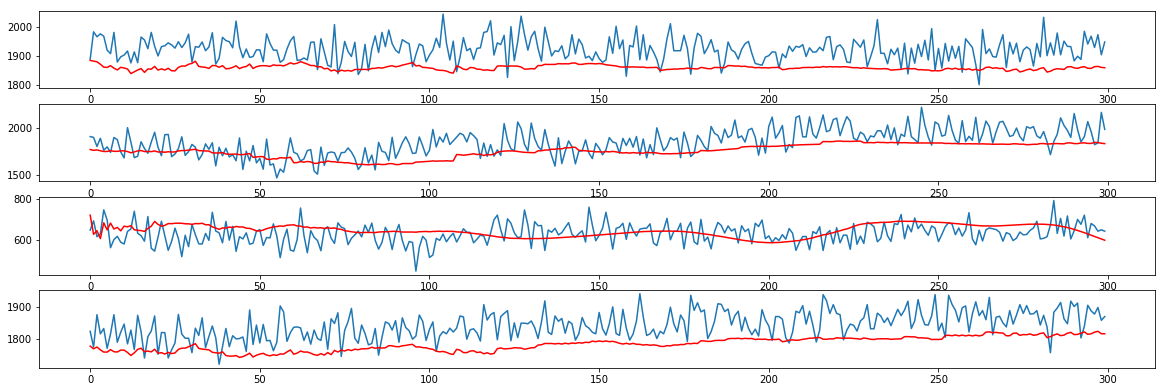

In [231]:
from keras import backend as K
from keras.models import load_model

sample_1 = data_block[np.newaxis, 1000]
output_1 = m.predict(sample_1)

sample_2 = data_block[np.newaxis, 10]
output_2 = m.predict(sample_2)

sample_3 = data_block[np.newaxis, 66]
output_3 = m.predict(sample_3)

sample_4 = data_block[np.newaxis, 6000]
output_4 = m.predict(sample_4)


plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(np.squeeze(sample_1))
plt.plot(np.squeeze(output_1), c='r')
plt.subplot(612)
plt.plot(np.squeeze(sample_2))
plt.plot(np.squeeze(output_2), c='r')
plt.subplot(613)
plt.plot(np.squeeze(sample_3))
plt.plot(np.squeeze(output_3), c='r')
plt.subplot(614)
plt.plot(np.squeeze(sample_4))
plt.plot(np.squeeze(output_4), c='r')


In [237]:
m.layers[14].get_config()

{'name': 'max_pooling1d_115',
 'padding': 'valid',
 'pool_size': (3,),
 'strides': (3,),
 'trainable': True}

In [239]:
embedding_model = keras.models.Model(inputs=m.input,
                                 outputs=m.layers[14].output)
embeddings = embedding_model.predict(data_block)
squished_embeddings = np.reshape(embeddings, (embeddings.shape[0], -1))

print(embeddings.shape)
print(squished_embeddings.shape)

np.save('../../Data/numpy-data/e11-embeddings-squished.npy', squished_embeddings)

(7155, 25, 8)
(7155, 200)
